In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import skew, kurtosis, norm, mode
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.preprocessing import quantile_transform
import psutil
%matplotlib inline

In [2]:
def preprocess(batch):

    freqs = batch[:,0]
    drifts = batch[:,1]
    snrs = batch[:,2]
    skews = batch[:,3]
    kurts = batch[:,4]
    sarles = batch[:,5]
    corrs = batch[:,6]
    tbws = batch[:,7]
    tskews = batch[:,8]
    tstds = batch[:,9]
    fstds = batch[:,10]
    sigbws = batch[:,11]

    normal_drifts = quantile_transform(drifts.reshape(len(drifts), 1), n_quantiles=100000, 
                                   output_distribution='normal', subsample=100000)
    normal_drifts = normal_drifts.reshape(len(normal_drifts))

    data_arr = np.array([np.argsort(np.argsort(freqs))/len(freqs),
                        #0.1*(freqs-np.min(freqs))/np.max(freqs-np.min(freqs)), 
                        np.abs(normal_drifts)/np.max(np.abs(normal_drifts)), 
                        (np.log10(snrs)-np.min(np.log10(snrs)))/np.max(np.log10(snrs)-np.min(np.log10(snrs))), 
                        (skews-np.min(skews))/np.max((skews-np.min(skews))), 
                        (np.log10(kurts)-np.min(np.log10(kurts)))/np.max(np.log10(kurts)-np.min(np.log10(kurts))), 
                        sarles, 
                        corrs, 
                        (np.log10(tbws*1e6)-np.min(np.log10(tbws*1e6)))/np.max(np.log10(tbws*1e6)-np.min(np.log10(tbws*1e6))),
                        (tskews-np.min(tskews))/np.max((tskews-np.min(tskews))),
                        (np.log10(tstds)-np.min(np.log10(tstds))),
                        (np.log10(fstds)-np.min(np.log10(fstds))),
                        sigbws/np.max(sigbws)
                        ])  ### PRE-PROCESSED FOR HDBSCAN

    data_arr_unscaled = np.array([freqs, 
                        drifts, 
                        snrs, 
                        skews, 
                        kurts, 
                        sarles, 
                        corrs, 
                        tbws*1e6, # units of Hz
                        tskews,
                        tstds,
                        fstds,
                        sigbws*1e6 # units of Hz
                        ])

    return np.transpose(data_arr), np.transpose(data_arr_unscaled)

In [13]:
hit_dats_array = np.concatenate((
    np.load('/datax/scratch/benjb/batch_1_dat_paths.npy', allow_pickle=True),
    np.load('/datax/scratch/benjb/batch_2_dat_paths.npy', allow_pickle=True),
    np.load('/datax/scratch/benjb/batch_3_dat_paths.npy', allow_pickle=True),
    np.load('/datax/scratch/benjb/batch_4_dat_paths.npy', allow_pickle=True),
    np.load('/datax/scratch/benjb/batch_5_dat_paths.npy', allow_pickle=True),
    np.load('/datax/scratch/benjb/batch_6_dat_paths.npy', allow_pickle=True),
))
print(hit_dats_array.shape)

(3247546, 2)


In [14]:
hit_params = np.load('/datax/scratch/benjb/C23_L_full_param_array.npy', allow_pickle=True)
print(hit_params.shape)
non_duplicate_hit_params = np.unique(hit_params, axis=0)
print(non_duplicate_hit_params.shape)

(2185987, 12)
(1917903, 12)


In [17]:
hit_dats = hit_dats_array[:][np.where((hit_dats_array[:,0] > 1100) & (hit_dats_array[:,0] < 1200) | 
                                        (hit_dats_array[:,0] > 1340) & (hit_dats_array[:,0] < 1900))]
print(len(hit_dats))

2185987


In [22]:
print(hit_dats[100000:100010, 0])
print(hit_params[100000:100010, 0])

[1197.787281 1197.778281 1197.772283 1197.769483 1197.756483 1197.751283
 1197.740381 1197.737283 1197.734279 1197.731882]
[1197.787281 1197.778281 1197.772283 1197.769483 1197.756483 1197.751283
 1197.740381 1197.737283 1197.734279 1197.731882]


In [24]:
dats_and_params = np.hstack((hit_params, hit_dats))
# second-to-last column is frequency, duplicate of first column
print(dats_and_params.shape)

(2185987, 14)


In [26]:
unique_dats_and_params = np.unique(dats_and_params.astype('str'), axis=0)

In [29]:
print(unique_dats_and_params[0])

['1100.004972' '-0.009566' '10.777426' '17.775218963623047'
 '364.6369083444104' '0.8692439024997649' '0.9643815080861455'
 '0.03884533143476941' '2.1249125003814697' '0.28232479095458984'
 '0.04715225100517273' '1.6763806343078613e-05' '1100.004972'
 '/home/obs/turboseti/AGBT21A_996_47/blc06/blc06_guppi_59405_66861_LeoA_0096.rawspec.0000/blc06_guppi_59405_66861_LeoA_0096.rawspec.0000.dat']


In [30]:
unique_params = unique_dats_and_params[:,:12].astype('float64')
unique_dats = unique_dats_and_params[:,-2:]

In [31]:
np.save('/datax/scratch/benjb/C23_L_unique_param_array.npy', unique_params)
np.save('/datax/scratch/benjb/C23_L_unique_dat_list.npy', unique_dats)

In [ ]:
### ENDED HERE 08/21/24

In [3]:
hit_params = np.load('/datax/scratch/benjb/C23_L_unique_param_array.npy', allow_pickle=True)
hit_dats = np.load('/datax/scratch/benjb/C23_L_unique_dat_list.npy', allow_pickle=True)
print(hit_params.shape)
print(hit_dats.shape)

(1917903, 12)
(1917903, 2)


In [5]:
print(hit_params[0])
print(hit_dats[0])

[ 1.10000497e+03 -9.56600000e-03  1.07774260e+01  1.77752190e+01
  3.64636908e+02  8.69243902e-01  9.64381508e-01  3.88453314e-02
  2.12491250e+00  2.82324791e-01  4.71522510e-02  1.67638063e-05]
['1100.004972'
 '/home/obs/turboseti/AGBT21A_996_47/blc06/blc06_guppi_59405_66861_LeoA_0096.rawspec.0000/blc06_guppi_59405_66861_LeoA_0096.rawspec.0000.dat']


In [18]:
round_2_idxs = np.load('/datax/scratch/benjb/C23_L_anomalous_hit_idxs.npy', allow_pickle=True)

round_2_hit_params = hit_params[round_2_idxs]
round_2_hit_dats = hit_dats[round_2_idxs]

In [16]:
full_params_and_dats = np.hstack((hit_params, hit_dats))

print(full_params_and_dats.shape)

(1917903, 14)

In [20]:
print(type(full_params_and_dats[0,0]))

<class 'numpy.str_'>


In [33]:
import shutil

for dat in np.unique(hit_dats):
    shutil.copy(dat, '/datax/scratch/benjb/C23_L_dats/')

In [78]:
#1688.9648423530161 - 1501.4648451469839

187.49999720603228

In [79]:
#print(len(hit_dats_array[:,0][np.where((hit_dats_array[:,0] > 1501.4648451469839) & (hit_dats_array[:,0] < 1688.9648423530161))[0]]))

934986


In [12]:
#2185987/218
#934986/199
1033697/207

4993.705314009662

In [31]:
# Rewrite HDBSCAN pipeline to process data first, then segment into batches.

n_batches = 207

hit_params = np.load('/datax/scratch/benjb/C23_L_full_param_array.npy', allow_pickle=True)
#hit_params = round_2_hit_params
stg_params = np.load('/datax/scratch/benjb/C23_L_full_injected_params.npy', allow_pickle=True)
hit_dats = np.load('/datax/scratch/benjb/C23_L_unique_dat_list.npy', allow_pickle=True)[:,1]
hit_dats = hit_dats[round_2_idxs]

#hit_params = hit_params[np.where((hit_params[:,0] > 1501.4648451469839) & (hit_params[:,0] < 1688.9648423530161))[0]]

print(hit_params.shape)
print(stg_params.shape)

full_params = np.vstack((hit_params, stg_params)) # need to be preprocessed together for quantile transforms

print(full_params.shape)

full_params_scaled, full_params_unscaled = preprocess(full_params)

print(full_params_scaled.shape)

# separate injected hits again so they can be re-injected into each batch later
hit_params_scaled = full_params_scaled[:-10]
hit_params_scaled = hit_params_scaled[round_2_idxs]
print(f'Size hit_params_scaled = {len(hit_params_scaled)}')
hit_params_unscaled = full_params_unscaled[:-10]
hit_params_unscaled = hit_params_unscaled[round_2_idxs]
print(f'Size hit_params_unscaled = {len(hit_params_unscaled)}')
stg_params_scaled = full_params_scaled[-10:]
stg_params_unscaled = full_params_unscaled[-10:]

batch_size = len(hit_params_scaled) // n_batches

hit_batches_scaled = []
hit_batches_unscaled = []
dat_batches = []

# shuffle hits before batching
#idxs = np.arange(2185987)
idxs = np.arange(len(hit_params_scaled))
np.random.shuffle(idxs) 
hit_params_scaled_shuffled = hit_params_scaled[idxs]
hit_params_unscaled_shuffled = hit_params_unscaled[idxs]
hit_dats_shuffled = hit_dats[idxs]
print(hit_params_scaled_shuffled.shape)

for i in range(n_batches):

    if i != n_batches-1:
        batch_scaled = hit_params_scaled_shuffled[i*batch_size:(i+1)*batch_size]
        batch_unscaled = hit_params_unscaled_shuffled[i*batch_size:(i+1)*batch_size]
        hit_dats_batch = hit_dats_shuffled[i*batch_size:(i+1)*batch_size]
    else:
        batch_scaled = hit_params_scaled_shuffled[i*batch_size:] # catch the last few entries in the final batch
        batch_unscaled = hit_params_unscaled_shuffled[i*batch_size:]
        hit_dats_batch = hit_dats_shuffled[i*batch_size:]


    #print(batch.shape)
    hit_batches_scaled.append(batch_scaled)
    hit_batches_unscaled.append(batch_unscaled)
    dat_batches.append(hit_dats_batch)

(2185987, 12)
(10, 12)
(2185997, 12)
(2185997, 12)
Size hit_params_scaled = 1033697
Size hit_params_unscaled = 1033697
(1033697, 12)


In [32]:
print(hit_batches_scaled[0].shape)
print(hit_batches_scaled[-1].shape)
print(dat_batches[0].shape)
print(dat_batches[-1].shape)

(4993, 12)
(5139, 12)
(4993,)
(5139,)


In [28]:
def batch_hdbscan(batch_arr_scaled, nmincluster, nminsamples, eps):

    hdb = HDBSCAN(
        min_cluster_size=nmincluster, 
        min_samples=nminsamples, 
        cluster_selection_epsilon=eps, 
        #metric = 'haversine',
        leaf_size=40,
        n_jobs=10,
        cluster_selection_method='eom')
    
    X = batch_arr_scaled
    hdb.fit(X)

    labels_list = hdb.labels_

    return labels_list

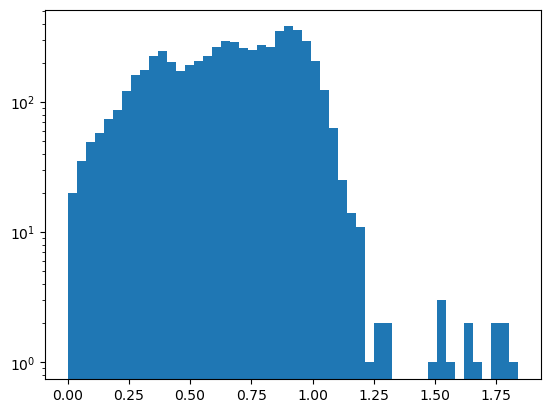

In [60]:
#plt.hist(bbb_scaled[:,10], bins=50)
#plt.yscale('log')
#plt.show()

In [17]:
#print(bbb_scaled.shape)

(7296, 12)


In [11]:
'''nmincluster = 4
nminsamples = 2
eps = 0.17

bbb_scaled = np.vstack((hit_batches_scaled[2], stg_params_scaled))
bbb_unscaled = np.vstack((hit_batches_unscaled[0], stg_params_unscaled))
#print(bbb.shape)
#bbb_scaled, bbb_unscaled = preprocess(bbb)

#plt.hist(bbb_scaled[0], bins=50)
#plt.yscale('log')
#plt.show()

print(bbb_scaled.shape)
print(bbb_unscaled.shape)

labels_list = batch_hdbscan(bbb_scaled, nmincluster, nminsamples, eps)

print(np.unique(labels_list))
print(labels_list[-10:])
print(len(np.where(labels_list==-1)[0]))
print(len(np.where(labels_list==-1)[0])/len(labels_list))
print(mode(labels_list)[1]/len(labels_list))'''

(5012, 12)
(5012, 12)
[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121]
[ 2 -1 -1  2  2  2  2 -1 -1  2]
1490
0.29728651237031123
0.4748603351955307


In [35]:
#for i in range(len(hit_batches_scaled)):

nmincluster = 3
nminsamples = 2
eps = 0.17

cluster_counts = []
dat_list_for_hit_deletion = np.empty((0, 2))
largest_cluster_sizes = []

for i in range(len(hit_batches_scaled)):
    print('-----')
    #bbb_scaled = hit_batches_scaled[i]
    bbb_scaled = np.vstack((hit_batches_scaled[i], stg_params_scaled))
    labels_list = batch_hdbscan(bbb_scaled, nmincluster, nminsamples, eps)
    dat_freq_obj = np.transpose(np.array([hit_batches_unscaled[i][:,0], dat_batches[i]], dtype='object'))
    non_anom_labels = np.array(list(set(np.unique(labels_list))-set(np.unique(np.concatenate((labels_list[-10:], [-1]))))))
    #print(non_anom_labels)
    mask = np.isin(labels_list[:-10], non_anom_labels)
    dat_freq_obj = dat_freq_obj[mask]

    #print(len(np.where(labels_list==-1)[0]))
    print(labels_list[-10:])
    #print(mask)
    #print(len(dat_freq_obj))
    print(f'{len(np.unique(labels_list))} unique clusters')
    print(f'{round(100*len(np.where(labels_list==-1)[0])/len(labels_list), 3)}% anomalies')
    print(f'{round(100*mode(labels_list)[1]/len(labels_list), 3)}% in largest cluster')

    cluster_counts.append(len(np.unique(labels_list)))
    largest_cluster_sizes.append(100*mode(labels_list)[1]/len(labels_list))
    dat_list_for_hit_deletion = np.concatenate((dat_list_for_hit_deletion, dat_freq_obj))

-----
[ 1 -1 -1  1  1  1  1 -1 -1 -1]
192 unique clusters
25.225% anomalies
50.81% in largest cluster
-----
[0 0 0 0 0 0 0 0 0 0]
3 unique clusters
0.04% anomalies
99.9% in largest cluster
-----
[ 0 -1 -1  0  0  0  0 -1 -1 -1]
229 unique clusters
25.365% anomalies
43.474% in largest cluster
-----
[ 5 -1 -1  5  5  5  5 -1 -1 -1]
206 unique clusters
26.804% anomalies
34.0% in largest cluster
-----
[0 0 0 0 0 0 0 0 0 0]
2 unique clusters
0.0% anomalies
99.94% in largest cluster
-----
[ 1  1 -1  1  1  1  1  1 -1  1]
206 unique clusters
27.104% anomalies
42.275% in largest cluster
-----
[ 2 -1 -1  2  2  2  2  2 -1  2]
208 unique clusters
24.945% anomalies
44.553% in largest cluster
-----
[ 1  1 -1  1  1  1  1  1 -1  1]
221 unique clusters
26.984% anomalies
34.299% in largest cluster
-----
[ 0  0 -1  0  0  0  0  0 -1  0]
188 unique clusters
25.745% anomalies
46.272% in largest cluster
-----
[0 0 0 0 0 0 0 0 0 0]
3 unique clusters
0.04% anomalies
99.88% in largest cluster
-----
[ 2 -1 -1  2  

In [39]:
process = psutil.Process()

print(process.memory_info().rss)

5044109312


In [40]:
np.save('/datax/scratch/benjb/C23_L_dat_list_for_hit_deletion_round2.npy', dat_list_for_hit_deletion)

In [49]:
dat_list_for_hit_deletion1 = np.load('/datax/scratch/benjb/C23_L_dat_list_for_hit_deletion.npy', allow_pickle=True)
dat_list_for_hit_deletion1_strings = [str(i[0]) + i[1] for i in dat_list_for_hit_deletion1]
np.save('/datax/scratch/benjb/C23_L_dat_list_for_hit_deletion_strings_round1.npy', dat_list_for_hit_deletion1_strings)

In [48]:
dat_list_for_hit_deletion_strings = [str(i[0]) + i[1] for i in dat_list_for_hit_deletion]

np.save('/datax/scratch/benjb/C23_L_dat_list_for_hit_deletion_strings_round2.npy', dat_list_for_hit_deletion_strings)

In [42]:
import numpy as np
dat_list_for_hit_deletion = np.load('/datax/scratch/benjb/C23_L_dat_list_for_hit_deletion_round2.npy', allow_pickle=True)
print(len(dat_list_for_hit_deletion))

557178


In [44]:
(1033697-557178)/1918067

0.24843709839124495

In [45]:
print(dat_list_for_hit_deletion[0][0])
print(dat_list_for_hit_deletion[0][1])

1619.204954
/home/obs/turboseti/AGBT21A_996_46/blc05/blc05_guppi_59404_01166_LeoT_0026.rawspec.0000/blc05_guppi_59404_01166_LeoT_0026.rawspec.0000.dat


In [46]:
import os

for i in range(len(dat_list_for_hit_deletion)):
    freq = dat_list_for_hit_deletion[i][0]
    dat_path = '/datax/scratch/benjb/C23_L_dats_round2/'+os.path.basename(dat_list_for_hit_deletion[i][1])
    if i%10000 == 0:
        print(f'{i}: Removing hit at frequency {freq} from {dat_path}')

    bytes_available = psutil.virtual_memory()[1]
    if bytes_available <= 32e9:
        print(f'Memory dangerously low: {bytes_available} bytes remaining. Breaking ...')
        break

    lines = []
    for line in open(dat_path):
        if not str(freq) in line:
            lines.append(line)

    with open(dat_path, 'w') as file:
        file.writelines(lines)
        file.close()

0: Removing hit at frequency 1619.204954 from /datax/scratch/benjb/C23_L_dats_round2/blc05_guppi_59404_01166_LeoT_0026.rawspec.0000.dat
10000: Removing hit at frequency 1176.684804 from /datax/scratch/benjb/C23_L_dats_round2/blc15_guppi_59902_31316_HIP60355_0079.rawspec.0000.dat
20000: Removing hit at frequency 1379.797317 from /datax/scratch/benjb/C23_L_dats_round2/blc03_guppi_59427_11033_CVnI_0074.rawspec.0000.dat
30000: Removing hit at frequency 1198.151585 from /datax/scratch/benjb/C23_L_dats_round2/blc04_guppi_59404_34880_NGC596_0128.rawspec.0000.dat
40000: Removing hit at frequency 1534.569831 from /datax/scratch/benjb/C23_L_dats_round2/blc05_guppi_59426_85157_NGC4551_0036.rawspec.0000.dat
50000: Removing hit at frequency 1679.726711 from /datax/scratch/benjb/C23_L_dats_round2/blc05_guppi_59405_47419_HIP8216_0037.rawspec.0000.dat
60000: Removing hit at frequency 1529.993839 from /datax/scratch/benjb/C23_L_dats_round2/blc05_guppi_59405_67827_HIP49565_0099.rawspec.0000.dat
70000: R

0.7294685990338164


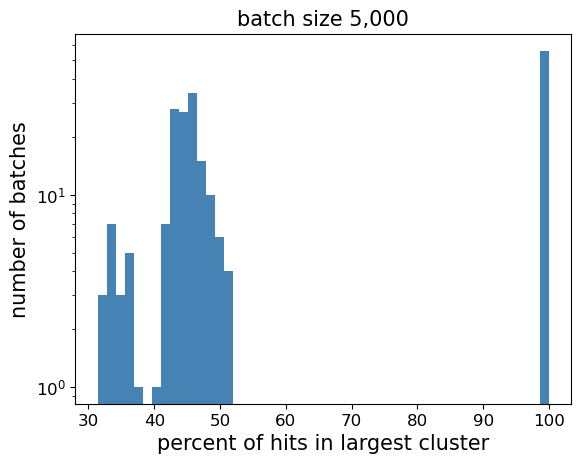

In [38]:
print(1-len(np.where(np.array(largest_cluster_sizes)>90)[0])/len(largest_cluster_sizes))
plt.hist(largest_cluster_sizes, color='steelblue', bins=50)
plt.yscale('log')
plt.xlabel('percent of hits in largest cluster', size=15)
#plt.xlabel('number of clusters in batch', size=15)
plt.ylabel('number of batches', size=15)
plt.title('batch size 5,000', size=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('/datax/scratch/benjb/C23_L_hyperparameter_selection_lg_cluster_pct_round2_5k_3_2_0.17.pdf', bbox_inches='tight')
#plt.savefig('/datax/scratch/benjb/C23_L_hyperparameter_selection_cluster_counts_round2_5k_3_2_0.17.pdf', bbox_inches='tight')
plt.show()

In [170]:
#for i in range(len(hit_batches_scaled)):
#for i in range(20):
#    print('-----')
#    avg_variances = []
#    for j in [3, 4, 5, 6, 7, 8]:
#        #bbb_scaled = np.vstack((hit_batches_scaled[i], stg_params_scaled[:6]))
 #       bbb_scaled = hit_batches_scaled[i]
 #       nmincluster = j
 #       nminsamples = 2
 #       eps = 0 
#        cluster_variances = []
#        labels_list = batch_hdbscan(bbb_scaled, nmincluster, nminsamples, eps)
#        for k in np.unique(labels_list[1:]):
#            cluster = bbb_scaled[np.where(labels_list==k)[0]]
#            #print(cluster.shape)
#            variance = np.std(cluster)
#            cluster_variances.append(variance)
#        avg_variances.append(np.mean(cluster_variances))
#    best_nmincluster = np.argmin(avg_variances) + 3
#    print(best_nmincluster)
#    labels_list = batch_hdbscan(bbb_scaled, best_nmincluster, nminsamples, eps)
#
#    #print(len(np.where(labels_list==-1)[0]))
#    print(labels_list[-5:])
#    print(f'{round(100*len(np.where(labels_list==-1)[0])/len(labels_list), 3)}% anomalies')
#    print(f'{round(100*mode(labels_list)[1]/len(labels_list), 3)}% in largest cluster')

-----
5
[108  -1  -1  -1  -1]
50.468% anomalies
50.468% in largest cluster
-----
5
[100  -1 126  -1   9]
46.616% anomalies
46.616% in largest cluster
-----
3
[ -1  29  -1 305 131]
44.359% anomalies
44.359% in largest cluster
-----
4
[ -1  -1 197  -1  -1]
50.128% anomalies
50.128% in largest cluster
-----
3
[ -1  -1  -1  -1 351]
42.593% anomalies
42.593% in largest cluster
-----
3
[0 0 0 0 0]
0.021% anomalies
99.872% in largest cluster
-----
3
[ -1 304 419  -1  76]
46.743% anomalies
46.743% in largest cluster
-----
3
[ 15 297  70  -1  -1]
41.975% anomalies
41.975% in largest cluster
-----
4
[34 -1 -1 -1 -1]
49.489% anomalies
49.489% in largest cluster
-----
4
[ -1 168  -1  59 148]
48.127% anomalies
48.127% in largest cluster
-----
3
[247 199 311  17  57]
43.21% anomalies
43.21% in largest cluster
-----
3
[165  -1  62 479  -1]
47.765% anomalies
47.765% in largest cluster
-----
3
[396 264  -1 371  -1]
49.021% anomalies
49.021% in largest cluster
-----
3
[190 114  -1 141  60]
43.252% anoma

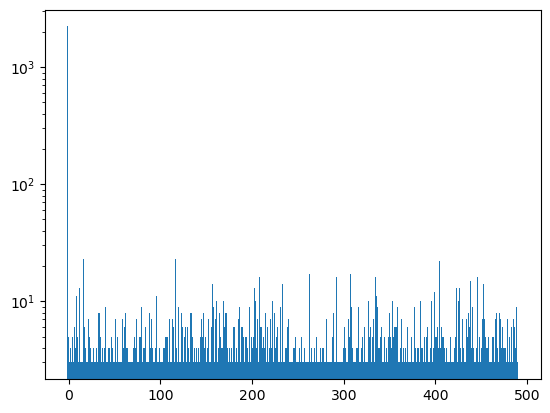

In [168]:
#plt.hist(labels_list, bins=len(np.unique(labels_list)), range=[-1.5, np.max(np.unique(labels_list))+0.5])
#plt.yscale('log')
#plt.show()

[-1  0  1]
Scattering ...
Refining ...


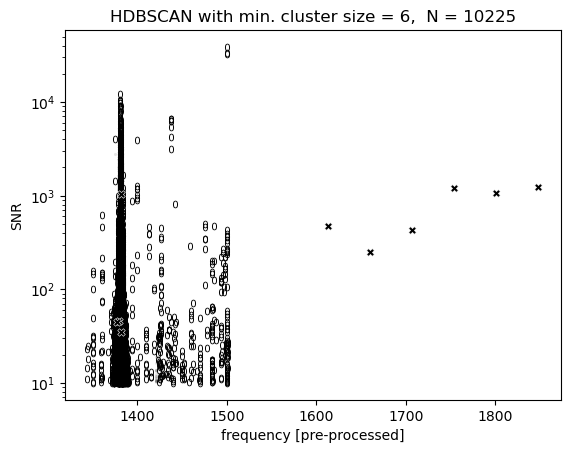

In [146]:
""" col_idx_x = 0
col_idx_y = 2

df = pd.DataFrame(bbb_scaled,
                   columns=['frequency [MHz]', 
                            'drift rate [Hz/s]', 
                            'log10 SNR', 
                            'skewness', 
                            'log10 kurtosis', 
                            'Sarle\'s coefficient', 
                            'correlation coefficient [kurtosis vs. log(bandwidth)]', 
                            'log10 turning-point bandwidth [Hz]', 
                            'temporal skewness', 
                            'log10 time-series standard deviation', 
                            'log10 power-spectrum standard deviation',
                            'signal bandwidth [Hz]'])

dfu = pd.DataFrame(bbb_unscaled,
                   columns=['frequency [pre-processed]', 
                            'drift rate [pre-processed]', 
                            'SNR', 
                            'spectral skewness', 
                            'spectral kurtosis', 
                            'Sarle\'s coefficient', 
                            'correlation coefficient [kurtosis vs. log(bandwidth)]', 
                            'turning-point bandwidth [Hz]', 
                            'temporal skewness', 
                            'time-series standard deviation', 
                            'power-spectrum standard deviation',
                            'signal bandwidth [Hz]'])

labels = np.unique(labels_list)
print(labels)

x_param = dfu.columns[col_idx_x]
y_param = dfu.columns[col_idx_y]

x = dfu[x_param].values
y = dfu[y_param].values

colors = cm.nipy_spectral(np.linspace(0, 1, len(labels)-1))

print('Scattering ...')
for l in labels[::-1]:
    idxs = np.where(labels_list == l)[0]
    if l == -1.:
        plt.scatter(x[idxs], y[idxs], color='k', s=5, alpha=0.1, linewidths=0, label=f'n={len(idxs)}')
    else:
        plt.scatter(x[idxs], y[idxs], marker=f'${l}$', color=colors[l], s=30, linewidths=0, label=f'n={len(idxs)}')

#other_idxs = np.array([3068, 3069, 3070])
plt.scatter(x[-10:], y[-10:], color='k', edgecolors='w', linewidths=0.4, s=30, marker='X')

print('Refining ...')

if 'log10' in df.columns[col_idx_x]:
    plt.xscale('log')
else:
    plt.xscale('linear')
if 'log10' in df.columns[col_idx_y]:
    plt.yscale('log')
else:
    plt.yscale('linear')

plt.xlabel(x_param)
plt.ylabel(y_param)
plt.title(f'HDBSCAN with min. cluster size = {nmincluster},  N = {len(x)}')

#leg = plt.legend(fontsize=8)
#for lh in leg.legendHandles: 
#    lh.set_alpha(1)
#    lh.set_sizes([30])
#plt.xscale('log')
#plt.yscale('log')

#plt.savefig(f'HDBSCAN_clustering_{col_idx_x}_{col_idx_y}.pdf')

plt.show() """

In [ ]:
### NEW WORK AS OF FALL 2024

In [3]:
dats_list = glob.glob('/datax/scratch/benjb/C23_L_dats/*.dat')
print(len(dats_list))

3078


In [7]:
hit_dats = hit_dats_array[:,1]

In [8]:
print(len(dats_list))

3078


In [9]:
counter = 0
counter2 = 0
#dats_list = np.unique(hit_dats)
lines = []

for ii, dat_path in enumerate(dats_list):

    #print(f'{ii} out of {len(dats_list)}')

    filename = dat_path
    #print(filename)

    df0 = pd.read_table(filename, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                                'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                                'Full_number_of_hits'], skiprows=9)
    
    #print(df0.keys())
    ff = df0['Uncorrected_Frequency'].values
    counter += len(ff[np.where(((ff>1100) & (ff<1200)) | ((ff>1340) & (ff<1900)))[0]])

    #xxx = hit_dats_array[np.where(hit_dats_array[:,1] == filename)[0]]

    #print(len(ff))
    #print(len(xxx))
    #if len(ff) != len(xxx):
        #print('Not a match!')
        #print(len(ff))
        #print(len(xxx))
    #    print(filename)
    #    lines.append(filename)
        #print('---')

    #counter += len(ff)
    #counter2 += len(xxx)

print(counter)
#with open('/datax/scratch/benjb/C23_L_possible_duplicates.txt', 'w') as file:
#    file.writelines(lines)
#    file.close()

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_468403/3500223554.py:13: SyntaxWarning: invalid escape sequence '\s'
  df0 = pd.read_table(filename, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',


947189


In [29]:
print(counter)
print(counter2)

2876858
3247546


In [33]:
filename = '/home/obs/turboseti/AGBT21A_996_47/blc02/blc02_guppi_59405_46775_HIP8938_0035.rawspec.0000/blc02_guppi_59405_46775_HIP8938_0035.rawspec.0000.dat'

xxx = hit_dats_array[np.where(hit_dats_array[:,1] == filename)[0]]

print(xxx)

[[1787.492593
  '/home/obs/turboseti/AGBT21A_996_47/blc02/blc02_guppi_59405_46775_HIP8938_0035.rawspec.0000/blc02_guppi_59405_46775_HIP8938_0035.rawspec.0000.dat']
 [1750.110199
  '/home/obs/turboseti/AGBT21A_996_47/blc02/blc02_guppi_59405_46775_HIP8938_0035.rawspec.0000/blc02_guppi_59405_46775_HIP8938_0035.rawspec.0000.dat']
 [1749.94453
  '/home/obs/turboseti/AGBT21A_996_47/blc02/blc02_guppi_59405_46775_HIP8938_0035.rawspec.0000/blc02_guppi_59405_46775_HIP8938_0035.rawspec.0000.dat']
 [1689.492999
  '/home/obs/turboseti/AGBT21A_996_47/blc02/blc02_guppi_59405_46775_HIP8938_0035.rawspec.0000/blc02_guppi_59405_46775_HIP8938_0035.rawspec.0000.dat']
 [1787.492593
  '/home/obs/turboseti/AGBT21A_996_47/blc02/blc02_guppi_59405_46775_HIP8938_0035.rawspec.0000/blc02_guppi_59405_46775_HIP8938_0035.rawspec.0000.dat']
 [1750.110199
  '/home/obs/turboseti/AGBT21A_996_47/blc02/blc02_guppi_59405_46775_HIP8938_0035.rawspec.0000/blc02_guppi_59405_46775_HIP8938_0035.rawspec.0000.dat']
 [1749.94453
  '/

In [37]:
a = np.array([[0, 1], [0, 0], [0, 1], [0, 2]])
print(np.unique(a, axis=0))

[[0 0]
 [0 1]
 [0 2]]


In [47]:
print(hit_dats_array[0].astype('str'))

['2250.899676'
 '/home/obs/turboseti/AGBT18A_999_103/collate/spliced_blc0001020304050607_guppi_58306_31766_DDO210_0002.gpuspec.0000/spliced_blc0001020304050607_guppi_58306_31766_DDO210_0002.gpuspec.0000.dat']


In [42]:
a = np.array([[0, 'b'], [0, 'c'], [0, 'b'], [0, 'd']])
print(np.unique(a, axis=0))

[['0' 'b']
 ['0' 'c']
 ['0' 'd']]


In [48]:
print(np.unique(hit_dats_array.astype('str'), axis=0).shape)

(2876688, 2)


In [51]:
3247546 - 2876688

370858

In [49]:
2876688 - 2876858

-170

In [ ]:
# 947,189 hits in dat files after filtering
# 1,918,067 hits in dat files before filtering
# ^^^ should be 2,186,151 (from C23)
#     (2,185,987 is the number after dropping hits too close to edge)

In [20]:
2186151-1918067

268084

In [53]:
with open('/datax/scratch/benjb/C23_L_possible_duplicates.txt', 'r') as file:
    s = file.read()
    file.close()

sss = s.split('/home/')

In [60]:
with open('/datax/scratch/benjb/C23_L_possible_duplicates.txt', 'w') as file:
    for s in sss:
        print('/home/' + s)
        file.write('/home/' + s + '\n')
    file.close()

/home/
/home/obs/turboseti/AGBT18A_999_103/collate/spliced_blc0001020304050607_guppi_58306_40769_Bol520_0016.gpuspec.0000/spliced_blc0001020304050607_guppi_58306_40769_Bol520_0016.gpuspec.0000.dat
/home/obs/turboseti/AGBT18A_999_103/collate/spliced_blc0001020304050607_guppi_58306_41409_Bol520_off_0017.gpuspec.0000/spliced_blc0001020304050607_guppi_58306_41409_Bol520_off_0017.gpuspec.0000.dat
/home/obs/turboseti/AGBT18A_999_103/collate/spliced_blc0001020304050607_guppi_58306_42049_Bol520_0018.gpuspec.0000/spliced_blc0001020304050607_guppi_58306_42049_Bol520_0018.gpuspec.0000.dat
/home/obs/turboseti/AGBT18A_999_103/collate/spliced_blc0001020304050607_guppi_58306_42687_Bol520_off_0019.gpuspec.0000/spliced_blc0001020304050607_guppi_58306_42687_Bol520_off_0019.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_134/blc00_blp00/blc00_guppi_58873_04241_NGC6946_0034.rawspec.0000/blc00_guppi_58873_04241_NGC6946_0034.rawspec.0000.dat
/home/obs/turboseti/AGBT19B_999_134/blc00_blp00/blc00_guppi_58873

In [65]:
filename = '/home/' + sss[5]
print(filename)
print(hit_dats_array[np.where(hit_dats_array[:,1] == filename)[0]])

/home/obs/turboseti/AGBT19B_999_134/blc00_blp00/blc00_guppi_58873_04241_NGC6946_0034.rawspec.0000/blc00_guppi_58873_04241_NGC6946_0034.rawspec.0000.dat
[[2250.899602
  '/home/obs/turboseti/AGBT19B_999_134/blc00_blp00/blc00_guppi_58873_04241_NGC6946_0034.rawspec.0000/blc00_guppi_58873_04241_NGC6946_0034.rawspec.0000.dat']
 [2250.893634
  '/home/obs/turboseti/AGBT19B_999_134/blc00_blp00/blc00_guppi_58873_04241_NGC6946_0034.rawspec.0000/blc00_guppi_58873_04241_NGC6946_0034.rawspec.0000.dat']
 [2250.599736
  '/home/obs/turboseti/AGBT19B_999_134/blc00_blp00/blc00_guppi_58873_04241_NGC6946_0034.rawspec.0000/blc00_guppi_58873_04241_NGC6946_0034.rawspec.0000.dat']
 [2250.59578
  '/home/obs/turboseti/AGBT19B_999_134/blc00_blp00/blc00_guppi_58873_04241_NGC6946_0034.rawspec.0000/blc00_guppi_58873_04241_NGC6946_0034.rawspec.0000.dat']
 [2250.487483
  '/home/obs/turboseti/AGBT19B_999_134/blc00_blp00/blc00_guppi_58873_04241_NGC6946_0034.rawspec.0000/blc00_guppi_58873_04241_NGC6946_0034.rawspec.0000.